In [1]:
from helperFunctions import *
from constants import *
import pyeeg


In [2]:
# Load XDF File

"""
Files that work
part_P001_block_S001.xdf # This does not have the cross hair
part_P002_block_S001.xdf # These have cross hairs
part_P003_block_S001.xdf # 20 images

part_P004_block_S001.xdf # 40 images
part_P005_block_S001.xdf # 40 images

part_P004_block_S002.xdf # 80 (last 40 not reshuffled). 
part_P004_block_S003.xdf # 80 (last 40 reshuffled) Weird high amplitude low freq noise. 
part_P006_block_S001.xdf # 80 (last 40 reshuffled) Large spikes at each image
part_P007_block_S001.xdf # 80 (last 40 reshuffled)

part_P001_block_S002.xdf # 280 (with 140 total images)
part_P001_block_S003.xdf # 280 (with 140 total images)


These experiments consist of the user looking at faces vs landscape as labeled by the Markers. 
In the more recent experiments, there are also cross hairs for the subject to fixate on before 
each new image is shown. 
"""
filename = "part_P001_block_S003"

XDF_Path = "./data/"+filename+".xdf"
XDF_Data = loadxdf(XDF_Path)

# Print the sampling frequency if found
if StreamType.EEG.value in XDF_Data : 
    eeg_fs = getEEGfs(XDF_Data) # int(XDF_Data[StreamType.EEG.value][StreamType.FS.value])
    print("eeg_fs = ", eeg_fs)
    
# Cut the data to drop anything before the psychopy stimuli presentation
XDF_Data = epochByMarkIndex(0, -1, XDF_Data)

eeg_fs =  128


Max time difference of eeg :	 0.011185760457465221
Min time difference of eeg :	 0.007068596289400375
Avg time difference of eeg (should be ~0.0078):		 0.008370152150345731
Mean eye sampling frequency (should be 128Hz):		 119.4721412511832
Number of eeg samples :	 61687


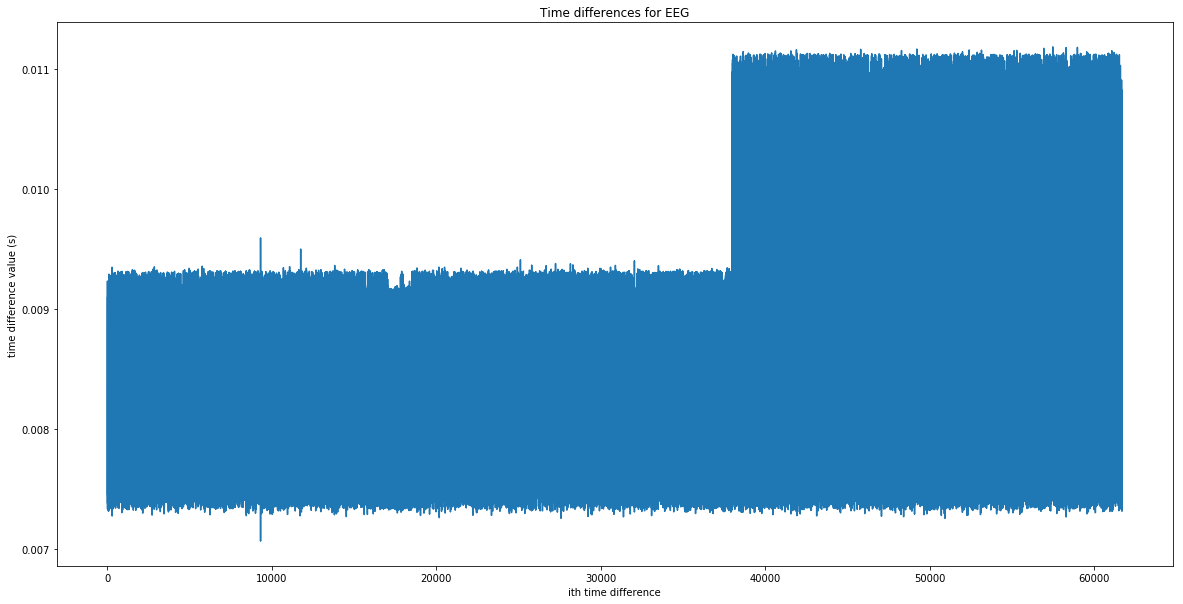

In [3]:
time_differences_eeg = [XDF_Data[StreamType.EEG.value][StreamType.TIME.value][i+1]-XDF_Data[StreamType.EEG.value][StreamType.TIME.value][i] for i in range(len(XDF_Data[StreamType.EEG.value][StreamType.TIME.value])-1)]
mean_fs_eeg = 1/np.mean(time_differences_eeg)
num_samples_eeg = len(XDF_Data[StreamType.EEG.value][StreamType.TIME.value])


print("Max time difference of eeg :\t", max(time_differences_eeg))
print("Min time difference of eeg :\t", min(time_differences_eeg))
print("Avg time difference of eeg (should be ~0.0078):\t\t", np.mean(time_differences_eeg))
print("Mean eye sampling frequency (should be 128Hz):\t\t", mean_fs_eeg)
print("Number of eeg samples :\t", num_samples_eeg)

# Visualize EEG recording gaps
plt.figure(figsize=(20,10))

plt.plot(time_differences_eeg)
plt.title("Time differences for EEG")
plt.xlabel("ith time difference")
plt.ylabel("time difference value (s)")
plt.show()


In [4]:
f_range = (0.5, 50)

In [5]:
# Measures from NeuroSky [Raw EEG, Attention, Meditation, Blinks]
print(sum(XDF_Data[StreamType.EEG.value][StreamType.DATA.value][:,3]), "blinks detected")

0.0 blinks detected


In [6]:
def convertRawToMicroVolts(raw_values):
    # http://support.neurosky.com/kb/science/how-to-convert-raw-values-to-voltage 
    # Converts an array of NeuroSky raw values into an array of millivolts 
    return (np.array(np.array(raw_values) * (1.8/4096)) / 2) * 1000

In [7]:
def getFilteredEEGDataInMicroVolts_fromEEGList(eeg_data):
    eeg_data_in_volts = convertRawToMicroVolts(eeg_data)
    sig_filt = filt.filter_signal(eeg_data_in_volts, eeg_fs, 'bandpass', f_range, filter_type='iir', butterworth_order=2)
    return sig_filt


In [8]:
def getEEGDataInMicroVolts(original_data):
    eeg_data = original_data[StreamType.EEG.value][StreamType.DATA.value][:,0]
    return getFilteredEEGDataInMicroVolts_fromEEGList(eeg_data)



In [9]:
def zeroTime(raw_timepoints):
    # Takes an array of timepoints and returns the zeroed version (where the )
    return np.array(np.array(raw_timepoints) - raw_timepoints[0])

In [10]:
def plotEEG(original_data, label="eeg"):
    eeg_data_in_volts = getEEGDataInMicroVolts(original_data)
    timepoints = original_data[StreamType.EEG.value][StreamType.TIME.value]
    
    plt.plot(timepoints, eeg_data_in_volts, label=label)

In [11]:
def plotAttention(original_data):
    data = original_data[StreamType.EEG.value][StreamType.DATA.value][:,1]
    timepoints = original_data[StreamType.EEG.value][StreamType.TIME.value]
    
    plt.plot(timepoints, data, label="attention")
    

In [12]:
def plotMeditation(original_data):
    data = original_data[StreamType.EEG.value][StreamType.DATA.value][:,2]
    timepoints = original_data[StreamType.EEG.value][StreamType.TIME.value]
    
    plt.plot(timepoints, data, label="meditation")

In [13]:
def plotPSD(original_data, cut_off=-1, label=None):
    eeg_data_in_volts = getEEGDataInMicroVolts(original_data)
    freq, psd = signal.periodogram(eeg_data_in_volts, fs=int(eeg_fs), scaling='spectrum')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('PSD')
    plt.plot(freq[:cut_off], psd[:cut_off], label=label)


In [14]:
def plotPSD_fromEEG(eeg_data, cut_off=-1, label=None):
    freq, psd = signal.periodogram(eeg_data, fs=int(eeg_fs), scaling='spectrum')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('PSD')
    plt.plot(freq[:cut_off], psd[:cut_off], label=label)
    return psd

In [15]:
def getPSD_fromEEG(eeg_data):
    freq, psd = signal.periodogram(eeg_data, fs=int(eeg_fs), scaling='spectrum')
    return psd

In [16]:
def getFreq_fromEEG(eeg_data):
    freq, psd = signal.periodogram(eeg_data, fs=int(eeg_fs), scaling='spectrum')
    return freq

In [17]:
def tidyNumList(lists, verbose=False):
    minimum_length = min(map(len, lists))
    cleaned_list = lists.copy()
    if minimum_length < 2: 
        toRemove = [i for i in range(len(lists)) if len(lists[i]) < 1]
        for i in toRemove:
            cleaned_list.pop(i)
        if verbose: 
            print("removed from lists:", [i for i in range(len(lists)) if len(lists[i]) < 1])
    minimum_length = min(map(len, cleaned_list))
    if verbose: 
        print("min length:", minimum_length)
    new_list = [cleaned_list[i][:minimum_length] for i in range(len(cleaned_list))]
    return new_list

In [18]:
## Getting bins for pyeeg.bin_power ## 
def getIntervals(binning): 
    intervals = list()
    for i, val in enumerate(binning[:-1]): 
        intervals.append((val, binning[i+1]))
    return intervals

In [19]:
def getPowerRatio(eeg_data, binning, eeg_fs=250):
    power, power_ratio = pyeeg.bin_power(eeg_data, binning, eeg_fs)
    return np.array(power_ratio)

In [20]:
def getSEM(numbers) :
    return (np.std(numbers, axis=0) * 2) / np.sqrt(len(numbers))


In [21]:
def getPowerRatioAvgSEM(eeg_list, binning): 
    power_ratio = [getPowerRatio(data[:], binning) for data in eeg_list]
    return np.mean(power_ratio, axis=0), getSEM(power_ratio)

In [22]:
def plotMultipleBarGraphs(bars, bar_width, bar_names, group_names, error_values=None, title=None, xlabel=None, ylabel=None): 
    if len(bar_names) != len(bars):
        print("group names must be same length as bars")
        return 
    # Set position of bar on X axis
    positions = list()
    positions.append(np.arange(len(bars[0])))
    for i, bar in enumerate(bars): 
        if i>0: 
            positions.append([x + bar_width for x in positions[i-1]])

    # Make the plot
    for i, pos in enumerate(positions):
        plt.bar(pos, bars[i], width=bar_width, label=bar_names[i])
    
    if error_values: 
        for i, pos in enumerate(positions):
            plt.errorbar(pos, bars[i], yerr=error_values[i], fmt='.k')
    
    # Add xticks on the middle of the group bars
    if xlabel: 
        plt.xlabel(xlabel)
    if ylabel: 
        plt.ylabel(ylabel)
    if title: 
        plt.title(title)
    plt.xticks([r + bar_width for r in range(len(bars[0]))], group_names)

    # Create legend & Show graphic
    plt.legend()
    plt.show()

/Users/glchau/anaconda3/envs/mne/lib/python3.6/site-packages/neurodsp/filt/filter.py:86: UserWarning: Edge artifacts are not removed when using an IIR filter.
  warn('Edge artifacts are not removed when using an IIR filter.')
/Users/glchau/anaconda3/envs/mne/lib/python3.6/site-packages/neurodsp/filt/iir.py:136: UserWarning: IIR filters are not recommended other than for notch filters.
  warn('IIR filters are not recommended other than for notch filters.')
/Users/glchau/anaconda3/envs/mne/lib/python3.6/site-packages/neurodsp/filt/utils.py:65: RuntimeWarning: divide by zero encountered in log10
  db = 20 * np.log10(abs(h_vals))
/Users/glchau/anaconda3/envs/mne/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
 

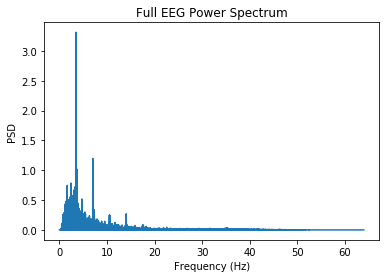

In [23]:
#plt.figure(figsize=(20,10))

plotPSD(XDF_Data)
plt.title("Full EEG Power Spectrum")
plt.show()

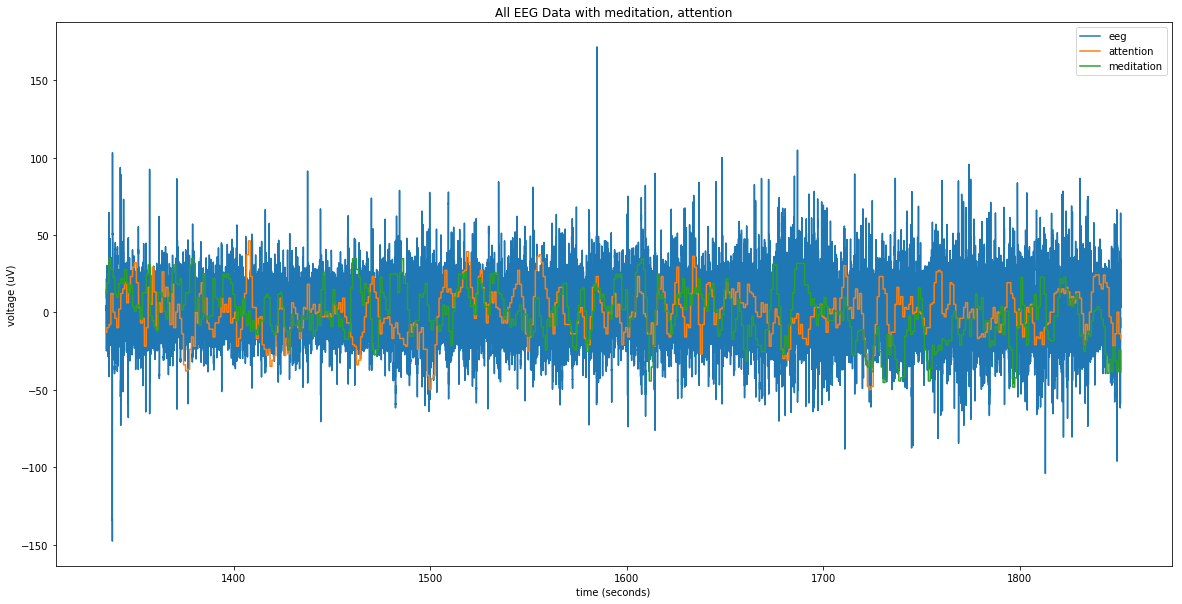

In [24]:
plt.figure(figsize=(20,10))

plotEEG(XDF_Data)
plotAttention(XDF_Data)
plotMeditation(XDF_Data)


plt.xlabel("time (seconds)")
plt.ylabel("voltage (uV)")
plt.title("All EEG Data with meditation, attention")
plt.legend()
plt.show()

In [25]:
blink, _, _ = getMarkerBoundSingleMarkerData('BlinkStart', 'BlinkEnd', XDF_Data, go_backward=False)
close_eye, _, _ = getMarkerBoundSingleMarkerData('CloseEyeStart', 'CloseEyeEnd', XDF_Data, go_backward=False)
trials, _, _ = getMarkerBoundSingleMarkerData('NewImageStart', 'NewImageEnd', XDF_Data, go_backward=False)
longer_trials, _, _ = getMarkerBoundSingleMarkerData('NewImageStart', 'CrossEnd', XDF_Data, go_backward=False)



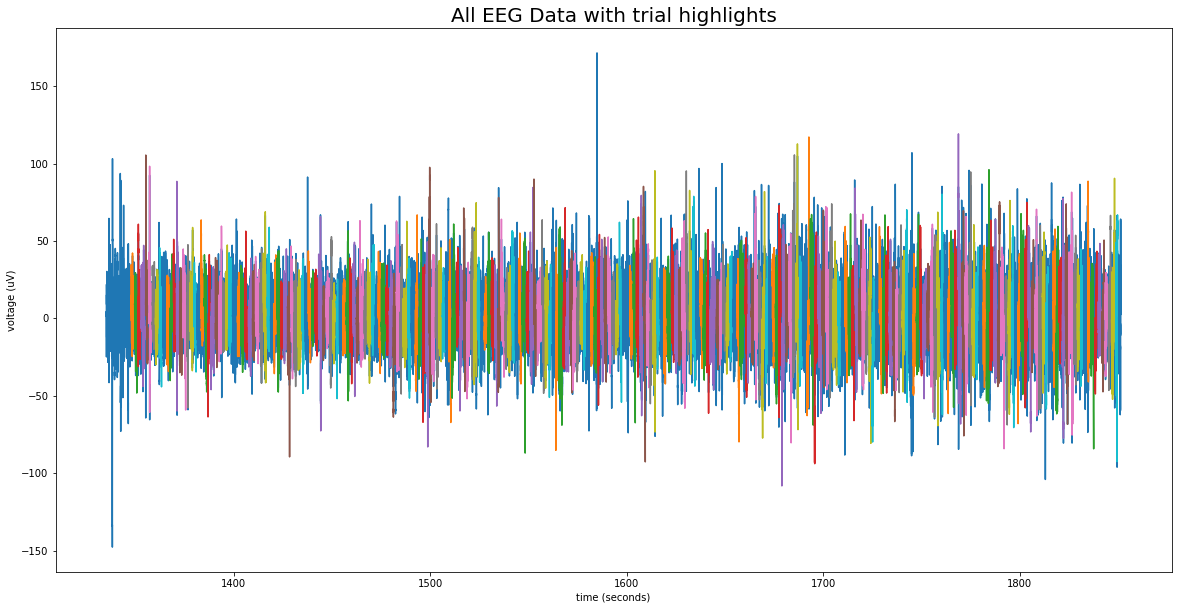

In [26]:
plt.figure(figsize=(20,10))

plotEEG(XDF_Data)

for i, trial in enumerate(trials):
    plotEEG(trial)

plt.xlabel("time (seconds)")
plt.ylabel("voltage (uV)")
plt.title("All EEG Data with trial highlights", size=20)
plt.show()


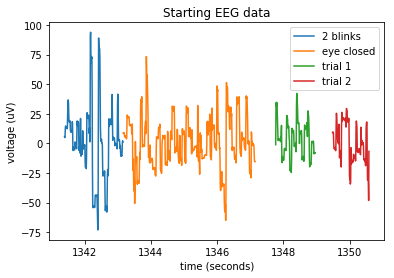

In [27]:
plotEEG(blink[0], label="2 blinks")
plotEEG(close_eye[0], label="eye closed")
plotEEG(trials[0], label="trial 1")
plotEEG(trials[1], label="trial 2")
plt.xlabel("time (seconds)")
plt.ylabel("voltage (uV)")
plt.legend()
plt.title("Starting EEG data")
plt.show()

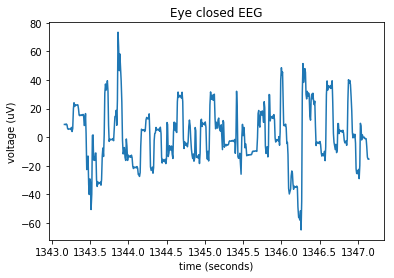

In [28]:
plotEEG(close_eye[0])
plt.title("Eye closed EEG")
plt.xlabel("time (seconds)")
plt.ylabel("voltage (uV)")
plt.show()

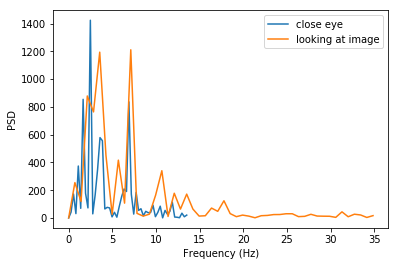

In [29]:
# View PSD of eye close vs trial
plotPSD_fromEEG(close_eye[0][StreamType.EEG.value][StreamType.DATA.value][20:,0], cut_off=50, label="close eye")
plotPSD_fromEEG(longer_trials[2][StreamType.EEG.value][StreamType.DATA.value][20:,0], cut_off=50, label="looking at image")
plt.legend()
plt.show()



In [30]:
# Find min length of eeg
min_len = None
for trial in trials: 
    eeg_data_in_volts = getEEGDataInMicroVolts(trial)
    if not min_len or len(eeg_data_in_volts) < min_len:
        min_len = len(eeg_data_in_volts)

# Find psd and freqs
psds=[]
freqs=[]
face_eeg = []
landscape_eeg = []
for trial in trials: 
    eeg_data_in_volts = getEEGDataInMicroVolts(trial)
    freq, psd = signal.periodogram(eeg_data_in_volts, fs=int(eeg_fs), scaling='spectrum')
    psds.append(psd)
    freqs.append(freq)
    if 'Face' in trial[StreamType.MARKER.value][StreamType.DATA.value]: 
        face_eeg.append(eeg_data_in_volts)
    else :
        landscape_eeg.append(eeg_data_in_volts)
    
    
    

In [31]:
# Create a binning interval
full_binning=list(np.arange(.5, 30, 2))
full_intervals = getIntervals(full_binning)

In [32]:
print("num faces", len(face_eeg), "num landscape", len(landscape_eeg))

num faces 140 num landscape 140


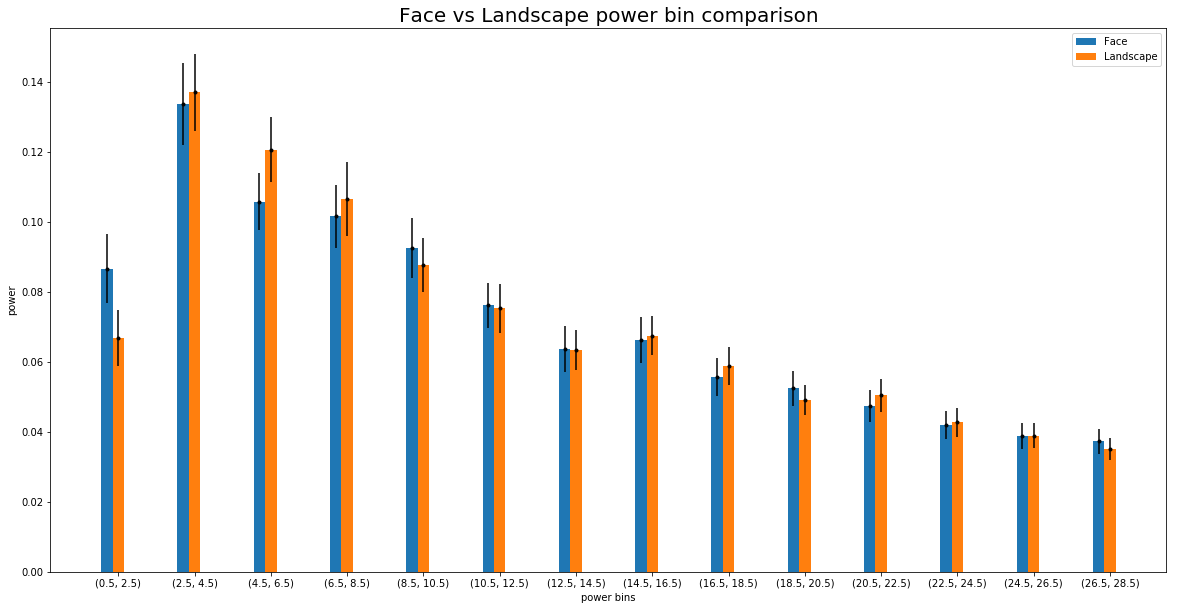

In [33]:
face_ratio_avg, face_sem = getPowerRatioAvgSEM(face_eeg, binning=full_binning) 
landscape_ratio_avg, landscape_sem = getPowerRatioAvgSEM(landscape_eeg, binning=full_binning) 

plt.figure(figsize=(20,10))
plt.title("Face vs Landscape power bin comparison", size=20)
plt.xlabel("power bins")
plt.ylabel("power")
plotMultipleBarGraphs([face_ratio_avg, landscape_ratio_avg], 0.15, ["Face", "Landscape"], full_intervals, error_values=[face_sem, landscape_sem])


In [34]:
# Create a binning interval
sub_binning=[0.5, 4, 7, 12, 30]
sub_intervals = getIntervals(sub_binning)

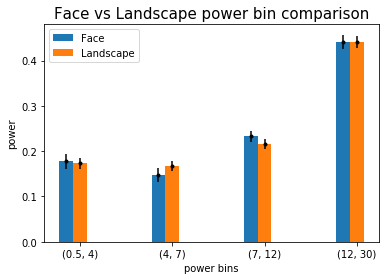

In [35]:
face_ratio_avg, face_sem = getPowerRatioAvgSEM(face_eeg, binning=sub_binning) 
landscape_ratio_avg, landscape_sem = getPowerRatioAvgSEM(landscape_eeg, binning=sub_binning) 

plt.title("Face vs Landscape power bin comparison", size=15)
plt.xlabel("power bins")
plt.ylabel("power")
plotMultipleBarGraphs([face_ratio_avg, landscape_ratio_avg], 0.15, ["Face", "Landscape"], sub_intervals, error_values=[face_sem, landscape_sem])


In [36]:
avg_face_signal = np.mean(tidyNumList(face_eeg), axis=0)
avg_landscape_signal = np.mean(tidyNumList(landscape_eeg), axis=0)

tidyEEGs = tidyNumList(face_eeg + landscape_eeg)

face_psds = [getPSD_fromEEG(eeg) for eeg in tidyEEGs[:len(tidyEEGs) // 2]]
landscape_psds = [getPSD_fromEEG(eeg) for eeg in tidyEEGs[len(tidyEEGs) // 2:]]

avg_face_psd = np.mean(face_psds, axis=0)
avg_landscape_psd = np.mean(landscape_psds, axis=0)


sem_face_signal = [getSEM(np.array(tidyNumList(face_eeg))[:,i]) for i in range(len(np.array(tidyNumList(face_eeg))[0]))]
sem_landscape_signal = [getSEM(np.array(tidyNumList(landscape_eeg))[:,i]) for i in range(len(np.array(tidyNumList(landscape_eeg))[0]))]

face_psds = [ signal.periodogram(eeg, fs=int(eeg_fs), scaling='spectrum')[1] for eeg in tidyNumList(face_eeg) ]
landscape_psds = [ signal.periodogram(eeg, fs=int(eeg_fs), scaling='spectrum')[1] for eeg in tidyNumList(landscape_eeg) ]

face_sem_psd = [getSEM(np.array(face_psds)[:,i]) for i in range(len(np.array(tidyNumList(face_psds)[0]))) ]
landscape_sem_psd = [getSEM(np.array(landscape_psds)[:,i]) for i in range(len(np.array(tidyNumList(landscape_psds)[0]))) ]



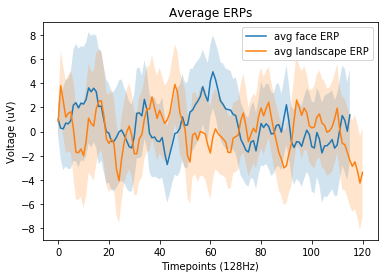

In [37]:
# View average ERPs for Face vs Landscape
plt.plot(avg_face_signal, label="avg face ERP")
plt.plot(avg_landscape_signal, label="avg landscape ERP")
# plt.plot(face_eeg[0], label="example face ERP")
# plt.plot(landscape_eeg[0], label="example landscape ERP")
plt.fill_between(list(range(len(avg_face_signal))), avg_face_signal-sem_face_signal, avg_face_signal+sem_face_signal, alpha = 0.2)
plt.fill_between(list(range(len(avg_landscape_signal))), avg_landscape_signal-sem_landscape_signal, avg_landscape_signal+sem_landscape_signal, alpha = 0.2)


plt.title("Average ERPs")
plt.ylabel("Voltage (uV)")
plt.xlabel("Timepoints (128Hz)")
plt.legend()
plt.show()

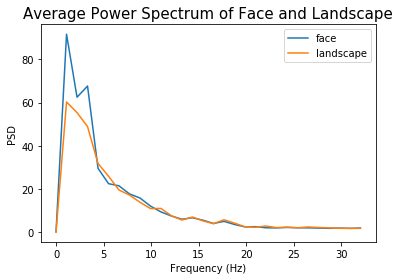

In [38]:
# Compare average psd with standard error of mean
cut_off = 30
freq = getFreq_fromEEG(tidyNumList(face_eeg)[0])

plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD')
plt.plot(freq[:cut_off], avg_face_psd[:cut_off], label="face")
plt.plot(freq[:cut_off], avg_landscape_psd[:cut_off], label="landscape")


# face_psd_avg = plotPSD_fromEEG(avg_face_signal, label="face psd")
# landscape_psd_avg = plotPSD_fromEEG(avg_landscape_signal, label="landscape psd")
plt.title("Average Power Spectrum of Face and Landscape", size=15)

# plt.fill_between(list(range(len(face_psd_avg))), face_psd_avg-face_sem_psd, face_psd_avg+face_sem_psd, alpha = 0.2)
# plt.fill_between(list(range(len(landscape_psd_avg))), landscape_psd_avg-landscape_sem_psd, landscape_psd_avg+landscape_sem_psd, alpha = 0.2)


plt.legend()
plt.show()

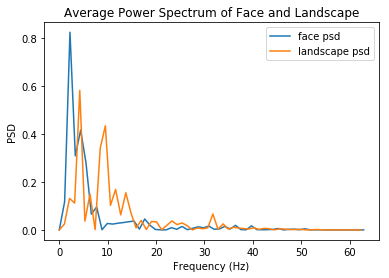

In [39]:
# Compare average psd with grand scheme PSD
#plotPSD(close_eye[0])
#plotPSD(trials[41])
plotPSD_fromEEG(avg_face_signal, label="face psd");
plotPSD_fromEEG(avg_landscape_signal, label="landscape psd");
plt.title("Average Power Spectrum of Face and Landscape")
plt.legend()
plt.show()